## Imports

In [158]:

# number stuff
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

#WCS

from owslib.wcs import WebCoverageService
import rasterio
from rasterio import plot
from PIL import Image
import rioxarray as rxr

# API

import requests

# OS

import os
from os.path import exists, join
from os import listdir

# Creating Facts

In [46]:
phi = np.cos(50/180)

a = 6378137
b = 6356752

resX = 250 / (2*np.pi*a/360) / np.cos(phi)
resY = 250 / (2*np.pi*(a + b) / 2 / 360)

Germany:

In [47]:
lon_min = 5.7
lat_min = 47.1
lon_max = 15.4
lat_max = 55.1

bbox = (lon_min, lat_min, lon_max, lat_max)

In [53]:
properties_list = ['bdod', 'cec', 'cfvo', 'clay', 'nitrogen', 'phh2o', 'sand', 'silt', 'soc', 'ocd', 'ocs']

# Collecting Data

### One Run_through

In [18]:
for i in range(3):
    wcs = WebCoverageService(f"http://maps.isric.org/mapserv?map=/map/{properties_list[i]}.map", version='1.0.0')
    print(wcs.contents)

{'bdod_0-5cm_Q0.5': <owslib.coverage.wcs100.ContentMetadata object at 0x150435520>, 'bdod_0-5cm_Q0.05': <owslib.coverage.wcs100.ContentMetadata object at 0x150435370>, 'bdod_0-5cm_Q0.95': <owslib.coverage.wcs100.ContentMetadata object at 0x1504351c0>, 'bdod_0-5cm_mean': <owslib.coverage.wcs100.ContentMetadata object at 0x150435250>, 'bdod_0-5cm_uncertainty': <owslib.coverage.wcs100.ContentMetadata object at 0x1504350d0>, 'bdod_5-15cm_Q0.5': <owslib.coverage.wcs100.ContentMetadata object at 0x1504350a0>, 'bdod_5-15cm_Q0.05': <owslib.coverage.wcs100.ContentMetadata object at 0x150435280>, 'bdod_5-15cm_Q0.95': <owslib.coverage.wcs100.ContentMetadata object at 0x1504351f0>, 'bdod_5-15cm_mean': <owslib.coverage.wcs100.ContentMetadata object at 0x150435670>, 'bdod_5-15cm_uncertainty': <owslib.coverage.wcs100.ContentMetadata object at 0x150435040>, 'bdod_15-30cm_Q0.5': <owslib.coverage.wcs100.ContentMetadata object at 0x150435550>, 'bdod_15-30cm_Q0.05': <owslib.coverage.wcs100.ContentMetadata

In [38]:
list_of_keys = list(wcs.contents.keys())

In [43]:
mean_list = []

for key in list_of_keys:
    if key.endswith('mean'):
        mean_list.append(key)

mean_list

In [49]:
response = wcs.getCoverage(
    identifier='cfvo_0-5cm_mean', 
    crs='urn:ogc:def:crs:EPSG::4326',
    bbox= bbox, 
    resx=resX, resy=resY,
    format='GEOTIFF_INT16')

In [51]:
with open('../raw_data/test_test.tif', 'wb') as file:
    file.write(response.read())

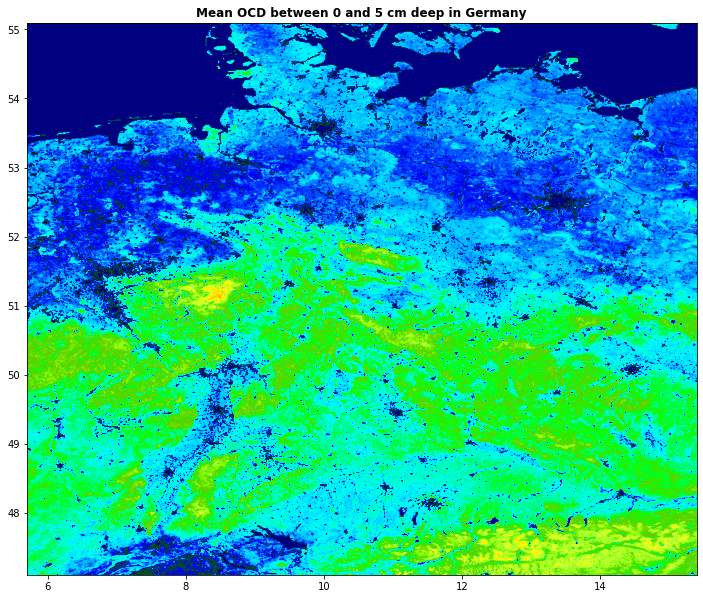

<AxesSubplot:title={'center':'Mean OCD between 0 and 5 cm deep in Germany'}>

In [52]:
ocd = rasterio.open('../raw_data/test_test.tif', driver="GTiff")
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(12, 12))
plot.show(ocd, title='Mean OCD between 0 and 5 cm deep in Germany', cmap='gist_ncar')

In [65]:
df = rxr.open_rasterio('../raw_data/test_test.tif')[0].to_pandas().unstack(level=-1).reset_index()

In [67]:
df.columns = ['longtitude', 'latitude', 'val']


In [77]:
df

,longtitude,latitude,val
0,5.701963,55.098875,0
1,5.701963,55.096626,0
2,5.701963,55.094376,0
3,5.701963,55.092126,0
4,5.701963,55.089876,0
...,...,...,...
8786871,15.398037,47.110124,147
8786872,15.398037,47.107874,147
8786873,15.398037,47.105624,148
8786874,15.398037,47.103374,0


## The Real Deal

In [127]:
def data_collector(properties_list):
    
    # Loop over every property that we want
    
    for prop in properties_list:
        
        # Connect to the server on that property
        
        wcs = WebCoverageService(f"http://maps.isric.org/mapserv?map=/map/{prop}.map", version='1.0.0')
        
        # Get each layer for that property
        
        list_of_keys = list(wcs.contents.keys())
        
        # Get only the mean values for each layer (and not the quartiles, median, etc.)
        
        mean_list = []
        
        for key in list_of_keys:
            
            if key.endswith('mean'):
                mean_list.append(key)
                
        # downloads data
        
        for layer in mean_list:

            # See if its already downloaded before an error occured:

            if exists(f'../raw_data/{layer}.tif') == False:

                # Calls the server
                try:
                    response = wcs.getCoverage(
                        identifier = layer, 
                        crs='urn:ogc:def:crs:EPSG::4326',
                        bbox= bbox,
                        resx=resX, resy=resY,
                        format='GEOTIFF_INT16')
                    
                except ConnectionError or HTTPError:
                    data_collector(properties_list)

                # Downloads the data

                with open(f'../raw_data/{layer}.tif', 'wb') as file:
                    file.write(response.read())


    
            
            

        
        

In [128]:
data_collector(properties_list)

In [150]:
def dick_of_df_creator():

    # Create an empty dictionary to be filled with dataframes of each layer for each feature

    output_dick = {}

    tif_names = listdir('../raw_data/')
    
    only_tif = []
    
    for tif in tif_names:
        if tif.endswith('tif'):
            only_tif.append(tif)


    for tif in only_tif:

        # Creates a df from downloaded data

        df = rxr.open_rasterio(f'../raw_data/{tif}')[0].to_pandas().unstack(level=-1).reset_index()

        df.columns = ['longtitude', 'latitude', tif[:-4]]

        # Fills output_dick with dfs

        output_dick[tif[:-4]] = df
        
    return output_dick
        

In [151]:
dic_of_df = dick_of_df_creator()

In [186]:
def dic_to_merged_data(dictionary_of_dfs):
    
    # sets df as first dataframe in dictionary

    df = dic_of_df[list(dic_of_df.keys())[0]]
    
    # merges every other dataframe in dictionary 
    
    for i in range(1, len(dic_of_df.keys())):

        df = df.merge(dic_of_df[list(dic_of_df.keys())[i]], on = ["longtitude", "latitude"])
    
    return df
        
    

In [187]:
merged_df = dic_to_merged_data(dic_of_df)

In [188]:
merged_df

,longtitude,latitude,sand_30-60cm_mean,sand_100-200cm_mean,bdod_0-5cm_mean,sand_60-100cm_mean,bdod_100-200cm_mean,cec_100-200cm_mean,clay_30-60cm_mean,nitrogen_30-60cm_mean,...,bdod_15-30cm_mean,cec_15-30cm_mean,silt_5-15cm_mean,cec_60-100cm_mean,phh2o_30-60cm_mean,cfvo_5-15cm_mean,soc_5-15cm_mean,clay_100-200cm_mean,bdod_60-100cm_mean,cfvo_30-60cm_mean
0,5.701963,55.098875,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.701963,55.096626,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.701963,55.094376,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.701963,55.092126,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.701963,55.089876,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8786871,15.398037,47.110124,365,409,121,378,151,170,233,207,...,135,189,437,178,59,150,423,235,150,177
8786872,15.398037,47.107874,384,425,124,394,150,143,217,182,...,135,162,420,149,60,151,275,216,148,170
8786873,15.398037,47.105624,383,433,120,398,147,161,219,171,...,135,171,423,170,61,163,302,206,145,194
8786874,15.398037,47.103374,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
!pwd

/Users/samueldrewes/code/ElCheckler/biodiversipy/notebooks


In [190]:
merged_df.to_csv('../raw_data/all_soilgrid_data')